In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [34]:
import pandas as pd
import numpy as np

# Set a seed for reproducibility
np.random.seed(42)

# Number of rows in the dataset
n_rows = 500

# --- 1. Base Columns (No Missing Data) ---
data = {
    'id': range(1, n_rows + 1),
    'age': np.random.randint(18, 70, size=n_rows),
    'city': np.random.choice(['New York', 'London', 'Paris', 'Tokyo', 'Berlin'], size=n_rows, p=[0.3, 0.25, 0.2, 0.15, 0.1]),
    'has_subscription': np.random.choice([True, False], size=n_rows, p=[0.6, 0.4])
}
df = pd.DataFrame(data)

# --- 2. Numerical Column with MCAR: `sensor_reading` ---
# Generate some sensor data
df['sensor_reading'] = np.random.normal(loc=100, scale=20, size=n_rows).round(2)
# Introduce MCAR missingness (approx 15%)
mcar_indices_sensor = np.random.choice(df.index, size=int(n_rows * 0.15), replace=False)
df.loc[mcar_indices_sensor, 'sensor_reading'] = np.nan

# --- 3. Categorical Column with MCAR: `preferred_device` ---
df['preferred_device'] = np.random.choice(['Phone', 'Tablet', 'Laptop', 'Desktop'], size=n_rows, p=[0.4, 0.2, 0.3, 0.1])
# Introduce MCAR missingness (approx 10%)
mcar_indices_device = np.random.choice(df.index, size=int(n_rows * 0.10), replace=False)
df.loc[mcar_indices_device, 'preferred_device'] = np.nan

# --- 4. Numerical Column with NMAR: `reported_income` ---
# True income (hypothetical, not directly in final dataset in this form)
# Let's make true income somewhat related to age for realism, but the NMAR part is key
true_income = 20000 + (df['age'] * 500) + np.random.normal(0, 15000, n_rows)
true_income[true_income < 10000] = 10000 # Floor income
df['reported_income'] = true_income.round(0)

# NMAR mechanism: People with very high or very low incomes are less likely to report
# Define thresholds based on the 'true_income' distribution
low_income_thresh = np.percentile(true_income, 15)  # Bottom 15%
high_income_thresh = np.percentile(true_income, 85) # Top 15%

# Probabilities of missing
prob_missing_low_income = 0.70  # 70% chance of missing if income is low
prob_missing_high_income = 0.60 # 60% chance of missing if income is high
prob_missing_mid_income = 0.05  # 5% chance for others

for i in df.index:
    # Use the 'true_income' for the decision, then make 'reported_income' missing
    actual_val = true_income[i] # The value that would have been reported
    if actual_val < low_income_thresh:
        if np.random.rand() < prob_missing_low_income:
            df.loc[i, 'reported_income'] = np.nan
    elif actual_val > high_income_thresh:
        if np.random.rand() < prob_missing_high_income:
            df.loc[i, 'reported_income'] = np.nan
    else:
        if np.random.rand() < prob_missing_mid_income:
            df.loc[i, 'reported_income'] = np.nan


# --- 5. Categorical Column with NMAR: `satisfaction_level` ---
# True satisfaction (hypothetical)
true_satisfaction = np.random.choice(['Very Unsatisfied', 'Unsatisfied', 'Neutral', 'Satisfied', 'Very Satisfied'],
                                     size=n_rows, p=[0.1, 0.15, 0.3, 0.3, 0.15])
df['satisfaction_level'] = true_satisfaction

# NMAR mechanism: People who are 'Very Unsatisfied' are less likely to report their satisfaction
prob_missing_very_unsatisfied = 0.75 # 75% chance of missing if 'Very Unsatisfied'
prob_missing_other_satisfaction = 0.05 # 5% for other categories

for i in df.index:
    actual_val = true_satisfaction[i] # The value that would have been reported
    if actual_val == 'Very Unsatisfied':
        if np.random.rand() < prob_missing_very_unsatisfied:
            df.loc[i, 'satisfaction_level'] = np.nan
    else:
        # Small chance of missing for other categories too, to make it less obvious
        if np.random.rand() < prob_missing_other_satisfaction:
             df.loc[i, 'satisfaction_level'] = np.nan

# --- Verification ---
print("Dataset head:")
print(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)

print("\n--- Verifying NMAR ---")
# For reported_income (Numerical NMAR)
# We expect more NaNs where true_income was low or high
# This is a bit tricky to verify directly without the 'true_income' column,
# but we designed it that way. We can look at the distribution of non-missing values.
if 'reported_income' in df.columns and df['reported_income'].isnull().any():
    print("\nReported Income (Numerical NMAR):")
    print("Distribution of non-missing reported_income:")
    print(df['reported_income'].dropna().describe())
    # If NMAR worked, the tails of the original distribution should be underrepresented.

# For satisfaction_level (Categorical NMAR)
# We expect 'Very Unsatisfied' to be underrepresented in non-missing values,
# and a higher proportion of its original occurrences to be NaN.
if 'satisfaction_level' in df.columns and df['satisfaction_level'].isnull().any():
    print("\nSatisfaction Level (Categorical NMAR):")
    print("Value counts of non-missing satisfaction_level:")
    print(df['satisfaction_level'].dropna().value_counts(normalize=True))
    print("\nOriginal (true) distribution of satisfaction_level (for comparison):")
    print(pd.Series(true_satisfaction).value_counts(normalize=True))
    # We expect 'Very Unsatisfied' to have a lower proportion in the non-missing data
    # than in the original 'true_satisfaction' data.

# Check that not all columns have missing values
if df.isnull().all().any():
    print("\nERROR: At least one column has ALL values missing, which shouldn't happen.")
elif not df.isnull().any().all():
    print("\nSUCCESS: Not all columns have missing values.")
else:
    print("\nERROR: All columns have at least one missing value.")


# Check number of columns with missing values
cols_with_missing = df.isnull().any()
num_cols_with_missing = cols_with_missing.sum()
print(f"\nNumber of columns with missing values: {num_cols_with_missing}")
if num_cols_with_missing >= 4:
    print("SUCCESS: At least 4 columns have missing values.")
else:
    print(f"FAILURE: Expected at least 4 columns with missing values, got {num_cols_with_missing}.")

# Verify specific column types and missingness patterns
print("\nSummary of designed missingness:")
print("- sensor_reading (Numerical MCAR): Missingness should be random.")
print("- preferred_device (Categorical MCAR): Missingness should be random.")
print("- reported_income (Numerical NMAR): Missingness depends on its own unobserved value (higher for very low/high incomes).")
print("- satisfaction_level (Categorical NMAR): Missingness depends on its own unobserved value (higher for 'Very Unsatisfied').")

# To save to CSV:
# df.to_csv("dataset_with_missing_values.csv", index=False)
# print("\nDataset saved to dataset_with_missing_values.csv")

Dataset head:
   id  age    city  has_subscription  sensor_reading preferred_device  \
0   1   56  Berlin              True          110.46           Laptop   
1   2   69   Paris             False           88.53           Tablet   
2   3   46   Paris              True             NaN           Tablet   
3   4   32   Paris              True          142.85            Phone   
4   5   60  London             False          134.55          Desktop   

   reported_income satisfaction_level  
0          50307.0            Neutral  
1              NaN        Unsatisfied  
2          17233.0     Very Satisfied  
3          40273.0            Neutral  
4              NaN            Neutral  

Missing values per column:
id                      0
age                     0
city                    0
has_subscription        0
sensor_reading         75
preferred_device       50
reported_income       112
satisfaction_level     57
dtype: int64

Data types:
id                      int64
age            

In [35]:
df.head()

,id,age,city,has_subscription,sensor_reading,preferred_device,reported_income,satisfaction_level
0,1,56,Berlin,True,110.46,Laptop,50307.0,Neutral
1,2,69,Paris,False,88.53,Tablet,NaN,Unsatisfied
2,3,46,Paris,True,NaN,Tablet,17233.0,Very Satisfied
3,4,32,Paris,True,142.85,Phone,40273.0,Neutral
4,5,60,London,False,134.55,Desktop,NaN,Neutral


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  500 non-null    int64  
 1   age                 500 non-null    int32  
 2   city                500 non-null    object 
 3   has_subscription    500 non-null    bool   
 4   sensor_reading      425 non-null    float64
 5   preferred_device    450 non-null    object 
 6   reported_income     388 non-null    float64
 7   satisfaction_level  443 non-null    object 
dtypes: bool(1), float64(2), int32(1), int64(1), object(3)
memory usage: 26.0+ KB


In [37]:
df.isnull().mean()*100

id                     0.0
age                    0.0
city                   0.0
has_subscription       0.0
sensor_reading        15.0
preferred_device      10.0
reported_income       22.4
satisfaction_level    11.4
dtype: float64

In [38]:
df.sample(10)

,id,age,city,has_subscription,sensor_reading,preferred_device,reported_income,satisfaction_level
7,8,56,Tokyo,True,102.40,Laptop,57618.0,Satisfied
122,123,24,Berlin,True,97.00,Laptop,29231.0,NaN
421,422,46,Tokyo,False,123.47,Laptop,26350.0,Neutral
72,73,21,Tokyo,True,114.55,Laptop,10000.0,Unsatisfied
49,50,42,Paris,True,106.93,Phone,NaN,Satisfied
381,382,58,Berlin,False,110.73,Laptop,46137.0,Very Satisfied
188,189,28,Berlin,False,71.95,Tablet,35475.0,Satisfied
82,83,65,London,False,141.77,Desktop,NaN,Very Unsatisfied
423,424,43,London,True,74.06,Tablet,44822.0,Very Satisfied
366,367,50,London,True,NaN,Phone,39732.0,Satisfied


<Axes: xlabel='sensor_reading', ylabel='Density'>

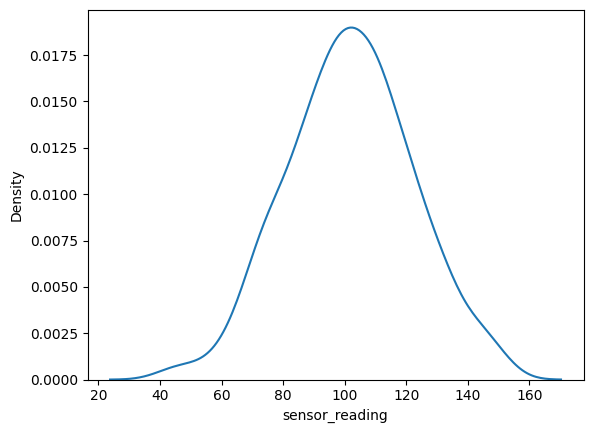

In [39]:
sns.kdeplot(df['sensor_reading'])

In [40]:
df.isnull().mean()*100

id                     0.0
age                    0.0
city                   0.0
has_subscription       0.0
sensor_reading        15.0
preferred_device      10.0
reported_income       22.4
satisfaction_level    11.4
dtype: float64

In [41]:
# 1. train test split the data
x = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

income == random

senosor == mean

device == missing

level == most frequent

In [42]:
# 2. filling the missing vals of the 3

tnf1 = ColumnTransformer([
    ('sensor_imputed', SimpleImputer(strategy='mean'), ['sensor_reading']),
    ('device_imputed', MissingIndicator(), ['preferred_device'])
], remainder='passthrough')

In [43]:
x_train['reported_income_impute'] = x_train['reported_income']
x_test['reported_income_impute'] = x_test['reported_income']

In [44]:
# 3. filling the income with random

mask = x_train['reported_income_impute'].isnull()
x_train['reported_income_impute'][mask] = x_train['reported_income'].dropna().sample(x_train['reported_income'].isnull().sum()).values

mask = x_test['reported_income_impute'].isnull()
x_test['reported_income_impute'][mask] = x_test['reported_income'].dropna().sample(x_test['reported_income'].isnull().sum()).values

C:\Users\UTSAV\AppData\Local\Temp\ipykernel_8976\2215721637.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  x_train['reported_income_impute'][mask] = x_train['reported_income'].dropna().sample(x_train['reported_income'].isnull().sum()).v

In [45]:
x_test.isnull().mean()

id                        0.000000
age                       0.000000
city                      0.000000
has_subscription          0.000000
sensor_reading            0.186667
preferred_device          0.120000
reported_income           0.253333
reported_income_impute    0.000000
dtype: float64

In [46]:
# for backup

train_report = x_train['reported_income']
test_report = x_test['reported_income']

In [47]:
x_train.isnull().mean()*100

id                         0.000000
age                        0.000000
city                       0.000000
has_subscription           0.000000
sensor_reading            14.352941
preferred_device           9.647059
reported_income           21.882353
reported_income_impute     0.000000
dtype: float64

In [48]:
x_train.drop(columns=['reported_income'], inplace=True)
x_test.drop(columns=['reported_income'], inplace=True)

In [49]:
new_train = tnf1.fit_transform(x_train)
new_test = tnf1.transform(x_test)

,id,age,city,has_subscription,sensor_reading,preferred_device,reported_income_impute
0,101.29,False,305,36,New York,True,43146.0
1,77.93,False,269,37,New York,False,32534.0
2,96.07,False,70,19,Tokyo,True,25182.0
3,112.97,False,456,23,Paris,True,34438.0
4,118.65,False,466,21,Berlin,True,46076.0
...,...,...,...,...,...,...,...
420,106.05,False,107,18,New York,True,42510.0
421,107.77,False,271,24,Tokyo,True,46289.0
422,91.13,False,349,68,New York,False,22527.0
423,64.78,False,436,63,Tokyo,True,38098.0


In [55]:
# encoding the cols

tnf2 = ColumnTransformer([
    ('level', LabelEncoder(), ['satisfaction_level'])
], remainder='passthrough')

In [ ]:

mask = x_train['reported_income_impute'].isnull()
col = x_train['reported_income']
values_req = col.isnull().sum()
x_train['reported_income_impute'][mask] = col.dropna().sample(values_req).values